# From emissions to concentrations of carbon-dioxide and methane
### PCS Day 3, Jan. 2022

# Overview:

We've now had some basic lectures on the carbon and methane cycles, and this allows us to now begin working in terms of *emissions*, rather than simply specifying concentrations. This is clearly more relevant to understanding modern climate change, because we have control over our emissions!

In this notebook we will look at the response of the climate to **pulse injections** of CO$_{2}$ and methane in our simple model. 

## Basic imports

- **Numpy** is a library built on top of C which allows you to perform rapid numerical calculations in Python and generate/manipulate arrays and matrices in a similar way to in MATLAB. <br>


- **Matplotlib** is the canonical plotting package in Python; as you might have guessed by the name, it's basically an open-source version of MATLAB's plotting functions. <br>
    - The '%matplotlib inline' comment just allows normal plotting within the Jupyter notebooks

In [1]:
%matplotlib inline

In [2]:
# Basic imports
import numpy as np
from matplotlib import pyplot as plt

In [14]:
import fair

# Check we're using v1.6.1 
print(f"We're using FaIR version {fair.__version__}") 

# The "engine" of fair is fair_scm, stored in the fair.forward class
from fair.forward import fair_scm

We're using FaIR version 1.6.1


# Model set up

Total delta T 10yr after emissions start = 0.04353
Total delta T 100yr after emissions start = 0.01427
Delta T from CO2 10yr after emissions start = 0.01827
Delta T from CO2 100yr after emissions start = 0.01314
Delta T from CH4 10yr after emissions start = 0.02526
Delta T from CH4 100yr after emissions start = 0.00117


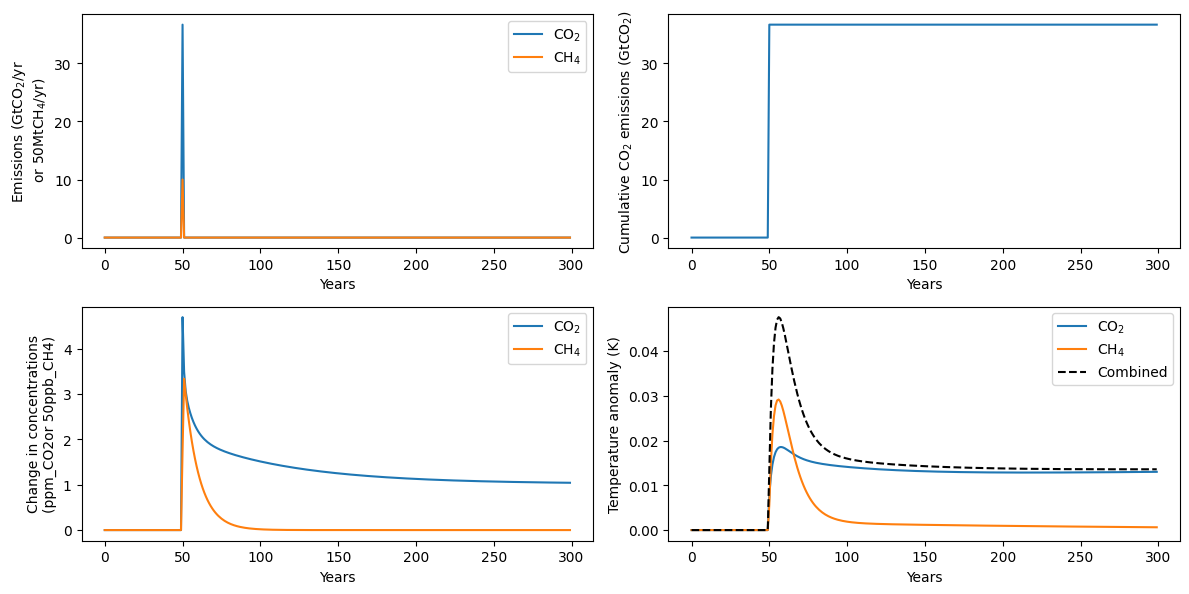

In [88]:
"""Set peak emissions rate of CO2 pulse, its duration and the year it starts. Note current emissions are ~37GtCO2/yr."""
peak_emissions_C = 37 # units are GtCO2/yr
duration_C       = 1 # units are years
year_start_C     = 50

"""Set the same parameters for the methane emissions pulse. Note current emissions are ~500MtCH4/yr."""
peak_emissions_M = 500 # units are MtCH4/yr, default 500
duration_M       = 1 # units are years, default 10
year_start_M     = 50
lifetime_M       = 9.3 # Lifetime of CH4, default 9.3 yrs

"""Set the same parameters for an N2O emissions pulse. Current emissions are ~9MtNO2/yr."""
peak_emissions_N = 0. # units are MtN2O/yr (keep this at zero for default...)
duration_N       = 10  # units are years
year_start_N     = 50
lifetime_N       = 121 # Lifetime of CH4, default 121 yrs


""" Set key model parameters """
ECS   = 2.7   # equilibrium climate sensitivity (K), default=2.7K
TCR   = 1.6   # transient climate response (K), default=1.6K
tau_s = 4.1   # ocean mixed layer response time scale (years), default=4.1yrs
tau_d = 239.0 # deep ocean response time scale (years), default=239.0yrs


# How long do we want to run for?
nyears = 300       

# Create time axis 
years  = np.arange(nyears) 


""" Adjust background emissions of N2O and CH4 to account for varying lifetimes """
from fair.constants import lifetime
from fair.tools import steady

# get steady state natural emissions for methane and n2o
# with appropriate preindustrial concentrations
steady_ch4_4yr = steady.emissions(species="CH4", lifetime=lifetime_M, C=722.)
steady_n2o     = steady.emissions(species="N2O", lifetime=lifetime_N, C=275.)

# load up default lifetimes but override methane and N2O if applicable
lt = lifetime.aslist
lt[1] = lifetime_M
lt[2] = lifetime_N


""" Create emissions time-series for CO2, CH4 and N2O (if applicable) """
# Create CO2 emissions time series
peak_emissions_C=peak_emissions_C*12/44  # convert from emissions of CO2 to emissions of C
emiss_C=np.zeros_like(years)
emiss_C[year_start_C:year_start_C+duration_C]=peak_emissions_C

# Create CH4 emissions time series
emiss_M=np.zeros_like(years)
emiss_M[year_start_M:year_start_M+duration_M]=peak_emissions_M

# Create N2O emissions time series
emiss_N=np.zeros_like(years)
emiss_N[year_start_N:year_start_N+duration_N]=peak_emissions_N

""" First, run FaIR for combined emissions """

emissions = np.zeros((nyears, 40))
emissions[:,1] = emiss_C
emissions[:,3] = emiss_M
emissions[:,4] = emiss_N

# turn off forcing for everything 
# except CO2, CH4 and N2O
scale = np.zeros(13)
scale[0] = 1.0 # CO2
scale[1] = 1.0 # CH4
scale[2] = 1.0 # N2O

C_pi = np.zeros((31))
C_pi[0:3] = [278., 722., 275.]

# run FAIR in default mode
C_tot,F_tot,T_tot = fair_scm(emissions, lifetimes=lt, 
                             natural = np.array([steady_ch4_4yr, steady_n2o]), 
                             F_volcanic=0., F_solar=0., # Switch off volcanos and solar forcing
                             C_pi = C_pi,
                             scale=scale, fixPre1850RCP=False)


""" Now, re-run the model with CO2 and CH4 emissions separately  """
emissions = np.zeros((nyears, 40))
emissions[:,1] = emiss_C

# turn off forcing for everything 
# except CO2, CH4 and N2O
scale = np.zeros(13)
scale[0] = 1.0 # CO2

C_pi = np.zeros((31))
C_pi[0:3] = [278.]

# run FAIR
C_co2,F_co2,T_co2 = fair_scm(emissions, lifetimes=lt, 
                             natural = np.array([0,0]), 
                             F_volcanic=0., F_solar=0., # Switch off volcanos and solar forcing
                             C_pi = C_pi,
                             tcrecs=np.array([TCR, ECS]),
                             scale=scale, fixPre1850RCP=False)


emissions = np.zeros((nyears, 40))
emissions[:,3] = emiss_M

# turn off forcing for everything 
# except CO2, CH4 and N2O
scale = np.zeros(13)
scale[1] = 1.0 # CH4
scale[2] = 1.0 # CH4

C_pi = np.zeros((31))
C_pi[0:3] = [278., 722., 275.]

# run FAIR
C_ch4,F_ch4,T_ch4 = fair_scm(emissions, lifetimes=lt, 
                             natural = np.array([steady_ch4_4yr, steady_n2o]), 
                             F_volcanic=0., F_solar=0., # Switch off volcanos and solar forcing
                             C_pi = C_pi,
                             tcrecs=np.array([TCR, ECS]),
                             scale=scale, fixPre1850RCP=False)

_,_,T_ch4_def = fair_scm(emissions, lifetimes=lt, 
                             natural = np.array([steady_ch4_4yr, steady_n2o]), 
                             F_volcanic=0., F_solar=0., # Switch off volcanos and solar forcing
                             C_pi = C_pi,
                             scale=scale, fixPre1850RCP=False)

emissions = np.zeros((nyears, 40))
emissions[:,4] = emiss_N

# turn off forcing for everything 
# except CO2, CH4 and N2O
scale = np.zeros(13)
scale[2] = 1.0 # N20

C_pi = np.zeros((31))
C_pi[0:3] = [278., 722., 275.]

# run FAIR
C_n2o,F_n2o,T_n2o = fair_scm(emissions, lifetimes=lt, 
                             natural = np.array([steady_ch4_4yr, steady_n2o]), 
                             F_volcanic=0., F_solar=0., # Switch off volcanos and solar forcing
                             C_pi = C_pi,
                             tcrecs=np.array([TCR, ECS]),
                             scale=scale, fixPre1850RCP=False)

""" Print stats """
#Calculate warming 10yr and 100yr after emissions begin across all gases. 
#Start by finding the earliest year at which emissions begin.
if (not np.all(emiss_M==0.)) and (not np.all(emiss_N==0.)):
    em_start_yr=min(year_start_C,year_start_M,year_start_N)
elif (not np.all(emiss_M==0.)):
    em_start_yr=min(year_start_C,year_start_M)
elif (not np.all(emiss_N==0.)):
    em_start_yr=min(year_start_C,year_start_N)
else:
    em_start_yr=year_start_C
    
print("Total delta T 10yr after emissions start = {:.5f}".format(T_tot[em_start_yr+10]))
print("Total delta T 100yr after emissions start = {:.5f}".format(T_tot[em_start_yr+100]))
if (not np.all(emiss_M==0.)) or (not np.all(emiss_N==0.)):
    print("Delta T from CO2 10yr after emissions start = {:.5f}".format(T_co2[em_start_yr+10]))
    print("Delta T from CO2 100yr after emissions start = {:.5f}".format(T_co2[em_start_yr+100]))
if (not np.all(emiss_M==0.)):
    print("Delta T from CH4 10yr after emissions start = {:.5f}".format(T_ch4[em_start_yr+10]))
    print("Delta T from CH4 100yr after emissions start = {:.5f}".format(T_ch4[em_start_yr+100]))
if (not np.all(emiss_N==0.)):
    print("Delta T from N2O 10yr after emissions start = {:.5f}".format(T_n2o[em_start_yr+10]))
    print("Delta T from N2O 100yr after emissions start = {:.5f}".format(T_n2o[em_start_yr+100]))

""" Plot """
fig, axs = plt.subplots(dpi=100, ncols=2, nrows=2, figsize=(12,6))

axs[0,0].plot(years, emiss_C*44/12, label='CO$_{2}$')
ylabel = "Emissions (GtCO$_{2}$/yr"
if not np.all(emiss_M==0):
    axs[0,0].plot(years, emiss_M/50, label='CH$_{4}$')
    ylabel += "\n or 50MtCH$_{4}$/yr"
if not np.all(emiss_N==0):
    axs[0,0].plot(years, emiss_N/10, label='N$_{2}$O')
    ylabel += "\n or 10MtN$_{2}$O/yr"
ylabel += ")"

axs[0,0].set_ylabel(ylabel)
axs[0,0].set_xlabel("Years")
axs[0,0].legend()

axs[0,1].plot(years, np.cumsum(emiss_C*44/12))
axs[0,1].set_ylabel("Cumulative CO$_{2}$ emissions (GtCO$_{2}$)")
axs[0,1].set_xlabel("Years")


axs[1,0].plot(years, C_co2[:,0]-C_co2[:,0][0], label='CO$_{2}$')
ylabel = "Change in concentrations\n(ppm_CO2"
if not np.all(emiss_M==0):
    axs[1,0].plot(years, C_ch4[:,1]/50 - (C_ch4[:,1]/50)[0], label='CH$_{4}$')
    ylabel += "or 50ppb_CH4"
if not np.all(emiss_N==0):
    axs[1,0].plot(years, C_n2o[:,2]/50 - (C_n2o[:,2]/50)[0], label='N$_{2}$O')
    ylabel += "\n or 50ppb_N2O"
ylabel += ")"
axs[1,0].set_ylabel(ylabel)
axs[1,0].set_xlabel("Years")
axs[1,0].legend()


axs[1,1].plot(years, T_co2, label='CO$_{2}$')

if not np.all(emiss_M==0):
    axs[1,1].plot(years, T_ch4, label='CH$_{4}$')
if not np.all(emiss_N==0):
    axs[1,1].plot(years, T_n2o, label='N$_{2}$O')
axs[1,1].plot(years, T_tot, color='black', linestyle='--', label='Combined')
axs[1,1].set_ylabel("Temperature anomaly (K)")
axs[1,1].set_xlabel("Years")
axs[1,1].legend()

fig.tight_layout()

## 1: Pulse injection of CO$_{2}$

Make sure the pulse duration is set to 1 year. Set the peak emissions of CH4 and N2O to zero.

 - Explain the main features of the CO2 concentration and warming curves.
 
 - What fraction of the emitted CO2 remains in the atmosphere after 10, 100 and 250 years (approximately)? 
 
 - How do the shapes of the CO2 concentration and warming curves change as the duration of the pulse is increased?

## 2: Pulse injection of CH$_{4}$

Set the peak emissions rate of the methane pulse to 500Mt/yr, that of the CO2 pulse to 37GtCO2/yr (the approximate present day anthropogenic emissions rates) and the durations of each to 1 year. 

 - How does the shape of the methane atmospheric concentration time series differ from that for CO2? Why?
 
 - How do the shapes of the temperature response curves for CO2 and methane differ and why?
 
 - What is the (approximate) relative importance of the effects of CO2 and methane on global mean temperature 10, 25 and 50 years after the emission time?